# **BAYESIAN HIERARCHICAL MODEL FOR FOOTBALL SCORES**

Load the required libraries and data.

In [ ]:
!pip install arviz

In [2]:
import arviz as az
from google.colab import files
import io
import pickle
import pystan
import pandas as pd
import numpy as np
import collections
from matplotlib import pyplot as plt

In [ ]:
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['scores.csv']))

Get the variables in their proper format for modelling in Stan.

In [6]:
ngames = df.shape[0]
ncomplete = np.sum(df.apply(lambda x:True if (x['home_goals']).isdigit() == True else False, axis=1))
npredict = ngames - ncomplete
#ngob = ngames - npredict
nteams = len(np.unique(df.iloc[:,1]))
home_name = df.iloc[0:ncomplete, 1]
away_name = df.iloc[0:ncomplete, 2]
home_name_new = df.iloc[ncomplete:ngames, 1]
away_name_new = df.iloc[ncomplete:ngames, 2]
home_team_index = pd.Categorical(df['home_team']).codes
away_team_index = pd.Categorical(df['away_team']).codes
#home_score = df.iloc[:, 5]
#away_score = df.iloc[:, 6]
home_score = df.iloc[0:ncomplete, 5]
home_score = pd.to_numeric(home_score)
away_score = df.iloc[0:ncomplete:, 6]
away_score = pd.to_numeric(away_score)
names = np.unique(home_name)

Now we need to increase all of the index values by one since Stan starts indexing at 1 not 0.

In [7]:
bleh = [1] * ngames
bleh += home_team_index
home_team_index = bleh

bleh = [1] * ngames
bleh += away_team_index
away_team_index = bleh

home_team_index_complete = home_team_index[0:ncomplete]
away_team_index_complete = away_team_index[0:ncomplete]
home_team_new = home_team_index[ncomplete:ngames]
away_team_new = away_team_index[ncomplete:ngames]

In [ ]:
away_team_index
home_team_index

### **MODEL FITTING**

Model 1: Standard Hierarchical Model

In [ ]:
model_1 = """
data {
  int<lower=0> nteams; //number of teams
  int<lower=0> ngames; //number of games
  int<lower=0> home_team[ngames]; //home team index
  int<lower=0> away_team[ngames]; //away team index
  int<lower=0> home_score[ngames]; //score home team
  int<lower=0> away_score[ngames]; //score away team
  int<lower=0> npredict; //number of games to predict
  int<lower=0> home_team_new[npredict]; //home teams for prediction
  int<lower=0> away_team_new[npredict]; //away teams for prediction
}

parameters {
  real home; //home advantage
  vector[nteams] att_star; 
  vector[nteams] def_star; 

  //hyperparameters

  real mu_att;
  real<lower = 0> sigma_att;
  real mu_def;
  real<lower = 0> sigma_def;
}

transformed parameters {
  vector[ngames] theta1; //score probability of home team
  vector[ngames] theta2; //score probability of away team
  vector[nteams] att; //attack ability of each team
  vector[nteams] def; //defence ability of each team

  att = att_star - mean(att_star);
  def = def_star - mean(def_star);
  
  theta1 = exp(home + att[home_team] + def[away_team]);
  theta2 = exp(att[away_team] + def[home_team]);
}

model {
  //hyperparams

  mu_att ~ normal(0, 100);
  sigma_att ~ inv_gamma(1, 1);
  mu_def ~ normal(0, 100);
  sigma_def ~ inv_gamma(1, 1);
}

  //priors
  att_star ~ normal(mu_att, sigma_att);
  def_star ~ normal(mu_def, sigma_def);
  home ~ normal(0, 100);

  //likelihood
  home_score ~ poisson(theta1);
  away_score ~ poisson(theta2);
}

generated quantities {
  //generated prediction
  vector[npredict] theta1new; //score probability of home team
  vector[npredict] theta2new; //score probability of away team
  real home_score_new[npredict]; //predicted home score
  real away_score_new[npredict]; //predicted away score

  theta1new = exp(home + att[home_team_new] + def[away_team_new]);
  theta2new = exp(att[away_team_new] + def[home_team_new]);

  home_score_new = poisson_rng(theta1new);
  away_score_new = poisson_rng(theta2new);
}
"""

Model 2: Hierarchical Mixture Model

In [8]:
model_2 = """
data {
  int<lower=0> nteams; //number of teams
  int<lower=0> ngames; //number of games
  int<lower=0> home_team[ngames]; //home team index
  int<lower=0> away_team[ngames]; //away team index
  int<lower=0> home_score[ngames]; //score home team
  int<lower=0> away_score[ngames]; //score away team
  int<lower=0> npredict; //number of games to predict
  int<lower=0> home_team_new[npredict]; //home teams for prediction
  int<lower=0> away_team_new[npredict]; //away teams for prediction
}

parameters {
  real home; //home advantage
  vector[nteams] att_star; 
  vector[nteams] def_star; 

  //hyperparameters

  //model 2
  vector[3] mu_att;
  vector<lower=0>[3] sigma_att;
  vector[3] mu_def;
  vector<lower=0>[3] sigma_def;

  simplex[3] pi_att; //probability vector for latent groups model 2
  simplex[3] pi_def;
}

transformed parameters {
  vector[ngames] theta1; //score probability of home team
  vector[ngames] theta2; //score probability of away team
  vector[nteams] att; //attack ability of each team
  vector[nteams] def; //defence ability of each team

  att = att_star - mean(att_star);
  def = def_star - mean(def_star);
  
  theta1 = exp(home + att[home_team] + def[away_team]);
  theta2 = exp(att[away_team] + def[home_team]);
}

model {
  vector[3] log_theta_att = log(pi_att);
  vector[3] log_theta_def = log(pi_def);

  //hyperparams
  //model 1
  
  //model 2
  mu_att[1] ~ normal(0, 10) T[-3, 0];
  mu_def[1] ~ normal(0, 10) T[0, 3];
  mu_att[2] ~ normal(0, sigma_att[2]);
  mu_def[2] ~ normal(0, sigma_def[2]);
  mu_att[3] ~ normal(0, 10) T[0, 3];
  mu_def[3] ~ normal(0, 10) T[-3, 0];

  sigma_att[1] ~ inv_gamma(1, 1);
  sigma_def[1] ~ inv_gamma(1, 1); 
  sigma_att[2] ~ inv_gamma(1, 1);
  sigma_def[2] ~ inv_gamma(1, 1);
  sigma_att[3] ~ inv_gamma(1, 1);
  sigma_def[3] ~ inv_gamma(1, 1);

  pi_att ~ dirichlet([1,1,1]');
  pi_def ~ dirichlet([1,1,1]');

  for (n in 1:nteams) {
    vector[3] lps_att = log_theta_att;
    vector[3] lps_def = log_theta_def;
    for (k in 1:3) {
      lps_att[k] += student_t_lpdf(att_star[n] | 4, mu_att[k], sigma_att[k]);
      lps_def[k] += student_t_lpdf(def_star[n] | 4, mu_def[k], sigma_def[k]);
    }
    target += log_sum_exp(lps_att);
    target += log_sum_exp(lps_def);
   
  }

  //priors
  //att_star ~ normal(mu_att, sigma_att); //model 1
  //def_star ~ normal(mu_def, sigma_def); //model 1
  home ~ normal(0, 100);

  //likelihood
  home_score ~ poisson(theta1);
  away_score ~ poisson(theta2);
}

generated quantities {
  //generated prediction
  vector[npredict] theta1new; //score probability of home team
  vector[npredict] theta2new; //score probability of away team
  real home_score_new[npredict]; //predicted home score
  real away_score_new[npredict]; //predicted away score

  theta1new = exp(home + att[home_team_new] + def[away_team_new]);
  theta2new = exp(att[away_team_new] + def[home_team_new]);

  home_score_new = poisson_rng(theta1new);
  away_score_new = poisson_rng(theta2new);
}
"""

data = {
    'nteams' : nteams,
    'ngames' : ncomplete,
    'home_team' : home_team_index_complete,
    'away_team' : away_team_index_complete,
    'home_score' : home_score,
    'away_score' : away_score,
    'npredict' : npredict,
    'home_team_new' : home_team_new,
    'away_team_new' : away_team_new
}

In [ ]:
mod = pystan.StanModel(model_code=model_2)
fit = mod.sampling(data = data, iter=15000, warmup=1000, chains=4, control=dict(max_treedepth = 14, adapt_delta = .9))

### **ASSESSING MODEL**

In [ ]:
print(fit)

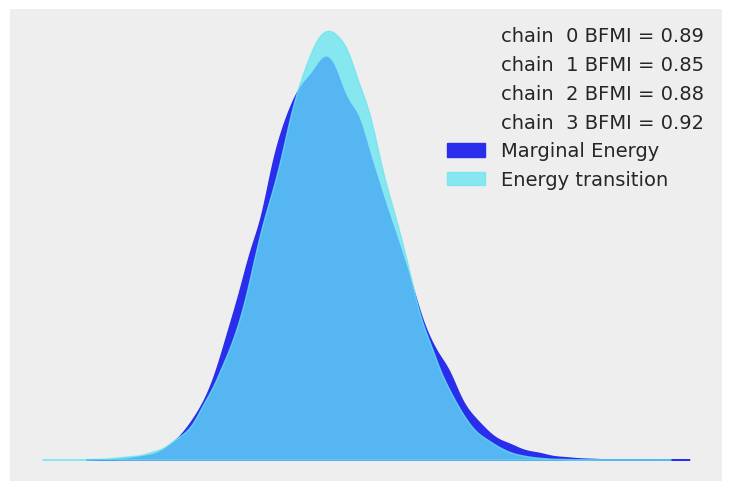

In [10]:
az.style.use('arviz-darkgrid')
inf_data = az.convert_to_inference_data(fit)
az.plot_energy(inf_data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7bdb29d110>,
      dtype=object)

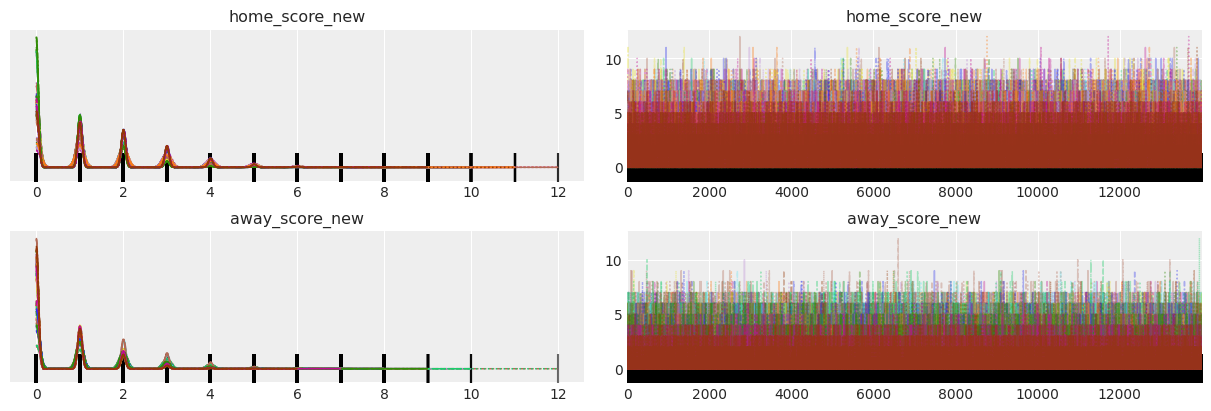

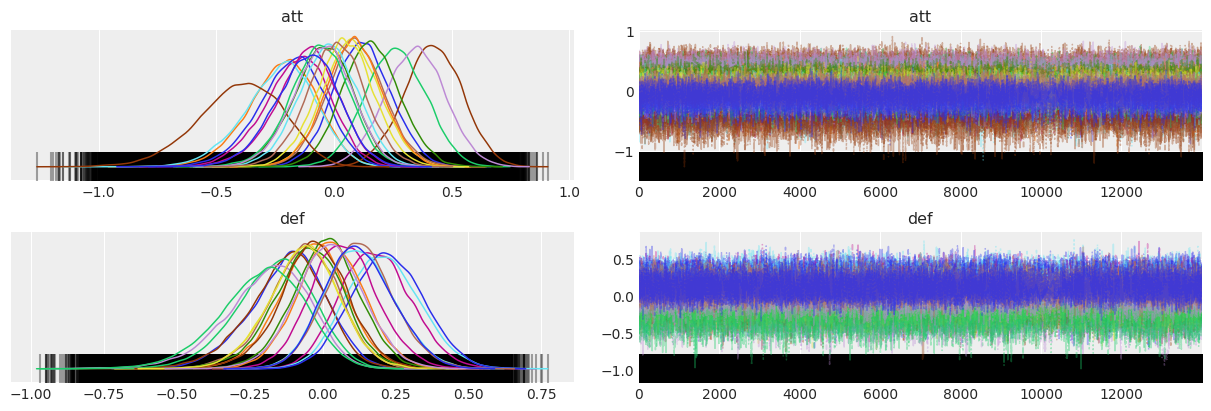

In [11]:
az.plot_trace(fit,var_names=['home_score_new', 'away_score_new'])
az.plot_trace(fit, var_names=['att', 'def'], combined=True)

INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates


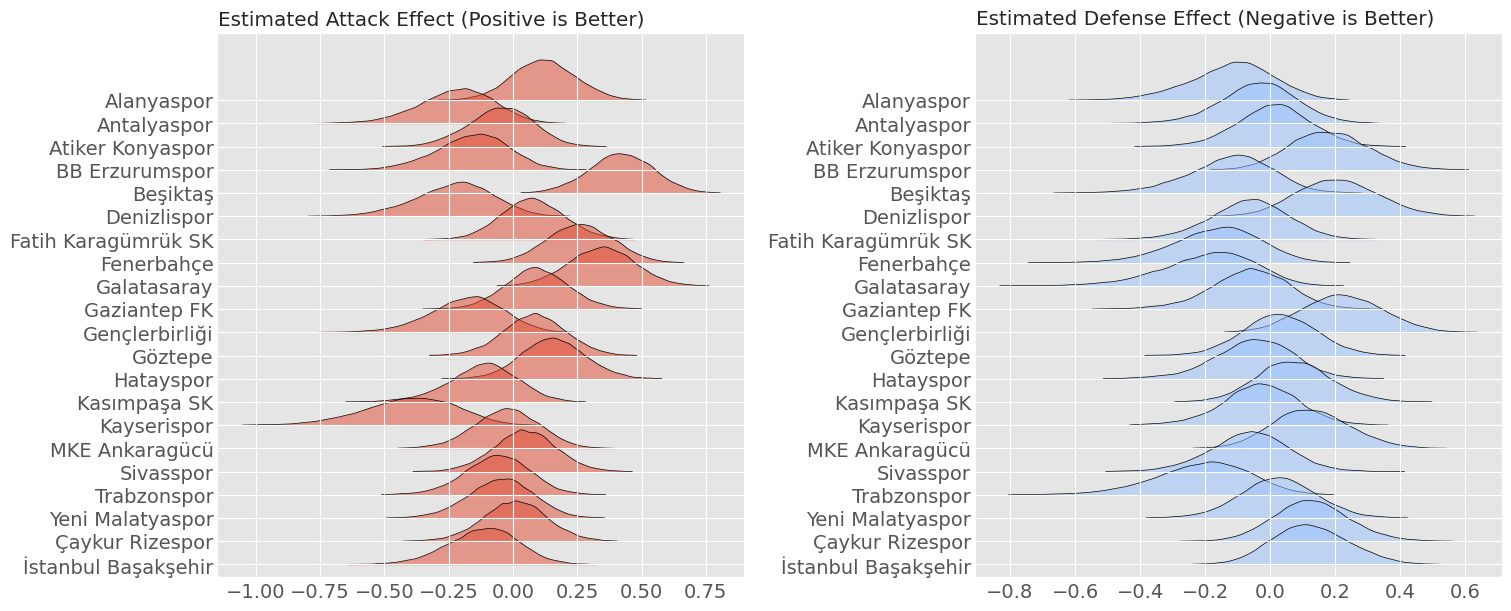

In [12]:
plt.style.use('ggplot')
_, ax = plt.subplots(1, 2, figsize=(15, 6))
az.plot_forest(fit, var_names="att",combined=True, ax=ax[0], kind='ridgeplot', ridgeplot_alpha=.5, ridgeplot_overlap=1.5, hdi_prob=.999, linewidth=.5)
ax[0].set_yticklabels(sorted(names, reverse=True))
ax[0].set_title('Estimated Attack Effect (Positive is Better)', loc='left')
ax[0].grid(True)
az.plot_forest(fit, var_names="def", combined=True, ax=ax[1], kind='ridgeplot', ridgeplot_alpha=.5, ridgeplot_overlap=1.5, colors='#99c2ff', hdi_prob=.999,
               linewidth=.5)
ax[1].set_yticklabels(sorted(names, reverse=True))
ax[1].set_title('Estimated Defense Effect (Negative is Better)', loc='left')
ax[1].grid(True)

In [ ]:
az.plot_parallel(inf_data, var_names=['sigma_att','sigma_def'])

In [ ]:
az.plot_posterior(fit)

### **PREDICTING NEW SCORES**

In [13]:
fitdf = fit.to_dataframe()
score_preds = fitdf.filter(regex='_score_new*')

In [14]:
dict_list = []
OU_dict = {}
ML_dict = {}

for i in range(1, npredict + 1):
  mydict = {}
  OU_list = []
  ML_list = []
  for j in range(0,len(score_preds['home_score_new['+str(i)+']'])):
    
    if not str(int(score_preds['home_score_new['+str(i)+']'][j])) + '-' + str(int(score_preds['away_score_new['+str(i)+']'][j])) in mydict:
      mydict[str(int(score_preds['home_score_new['+str(i)+']'][j])) + '-' + str(int(score_preds['away_score_new['+str(i)+']'][j]))] = 1
    else:
      mydict[str(int(score_preds['home_score_new['+str(i)+']'][j])) + '-' + str(int(score_preds['away_score_new['+str(i)+']'][j]))] += 1

    if (int(score_preds['home_score_new['+str(i)+']'][j]) > int(score_preds['away_score_new['+str(i)+']'][j])):
      ML_list.append(home_name_new.iloc[i - 1])
    elif (int(score_preds['home_score_new['+str(i)+']'][j]) < int(score_preds['away_score_new['+str(i)+']'][j])):
      ML_list.append(away_name_new.iloc[i - 1])
    else:
      ML_list.append("Draw")

    OU_list.append(int(score_preds['home_score_new['+str(i)+']'][j]) + int(score_preds['away_score_new['+str(i)+']'][j]))
  
  ML_dict[i] = ML_list
  OU_dict[i] = OU_list
  dict_list.append(mydict)

In [15]:
OUs_list = []
MLs_list = []
for i in range(1, len(OU_dict) + 1):
  OUs = {'Over' : 0, 'Under' : 0}
  MLs = {home_name_new.iloc[i - 1] : 0, 'Draw' : 0 , away_name_new.iloc[i - 1] : 0}
  for j in range(0, len(OU_dict[i])):
    if (OU_dict[i][j] > 2.5):
      OUs['Over'] += 1 
    else:
      OUs['Under'] += 1
    if (ML_dict[i][j] == home_name_new.iloc[i - 1]):
      MLs[home_name_new.iloc[i - 1]] += 1
    elif (ML_dict[i][j] == away_name_new.iloc[i - 1]):
      MLs[away_name_new.iloc[i - 1]] += 1
    else:
      MLs['Draw'] += 1
  
  OUs['Over'] = OUs['Over'] / (OUs['Over'] + OUs['Under'])
  OUs['Under'] = 1 - OUs['Over']
  OUs_list.append(OUs)
  Total = MLs[home_name_new.iloc[i - 1]] + MLs[away_name_new.iloc[i - 1]] + MLs['Draw']
  MLs[home_name_new.iloc[i - 1]] = MLs[home_name_new.iloc[i - 1]] / Total
  MLs['Draw'] = MLs['Draw'] / Total
  MLs[away_name_new.iloc[i - 1]] = MLs[away_name_new.iloc[i - 1]] / Total
  MLs_list.append(MLs)

In [16]:
for i in range(0, len(MLs_list)):
  print(MLs_list[i])

{'MKE Ankaragücü': 0.5641607142857142, 'Draw': 0.23335714285714285, 'Denizlispor': 0.20248214285714286}
{'BB Erzurumspor': 0.38155357142857144, 'Draw': 0.27248214285714284, 'Yeni Malatyaspor': 0.3459642857142857}
{'Galatasaray': 0.5735, 'Draw': 0.24532142857142858, 'Trabzonspor': 0.18117857142857144}
{'Alanyaspor': 0.4918571428571429, 'Draw': 0.25801785714285713, 'Gaziantep FK': 0.250125}
{'Kasımpaşa SK': 0.4765, 'Draw': 0.26607142857142857, 'İstanbul Başakşehir': 0.25742857142857145}
{'Gençlerbirliği': 0.3860892857142857, 'Draw': 0.26073214285714286, 'Çaykur Rizespor': 0.35317857142857145}
{'Atiker Konyaspor': 0.3878392857142857, 'Draw': 0.26748214285714284, 'Hatayspor': 0.34467857142857145}
{'Trabzonspor': 0.4468214285714286, 'Draw': 0.2886964285714286, 'Fatih Karagümrük SK': 0.26448214285714283}
{'Antalyaspor': 0.2626428571428571, 'Draw': 0.27003571428571427, 'Galatasaray': 0.46732142857142855}
{'Beşiktaş': 0.7162857142857143, 'Draw': 0.1883392857142857, 'Kayserispor': 0.095375}
{'D

In [17]:
for i in range(0, len(OUs_list)):
  print(home_name_new.iloc[i] + '-' + away_name_new.iloc[i] + ': ' + str(OUs_list[i]))

MKE Ankaragücü-Denizlispor: {'Over': 0.48857142857142855, 'Under': 0.5114285714285715}
BB Erzurumspor-Yeni Malatyaspor: {'Over': 0.42960714285714285, 'Under': 0.5703928571428571}
Galatasaray-Trabzonspor: {'Over': 0.433625, 'Under': 0.5663750000000001}
Alanyaspor-Gaziantep FK: {'Over': 0.45525, 'Under': 0.5447500000000001}
Kasımpaşa SK-İstanbul Başakşehir: {'Over': 0.4311785714285714, 'Under': 0.5688214285714286}
Gençlerbirliği-Çaykur Rizespor: {'Over': 0.48726785714285714, 'Under': 0.5127321428571429}
Atiker Konyaspor-Hatayspor: {'Over': 0.45385714285714285, 'Under': 0.5461428571428572}
Trabzonspor-Fatih Karagümrük SK: {'Over': 0.3644107142857143, 'Under': 0.6355892857142857}
Antalyaspor-Galatasaray: {'Over': 0.41480357142857144, 'Under': 0.5851964285714286}
Beşiktaş-Kayserispor: {'Over': 0.5061071428571429, 'Under': 0.49389285714285713}
Denizlispor-Sivasspor: {'Over': 0.4212142857142857, 'Under': 0.5787857142857142}
Yeni Malatyaspor-MKE Ankaragücü: {'Over': 0.466875, 'Under': 0.533125

In [ ]:
probs_list = []
for i in range(0, npredict):
  probs = {}
  for key in dict_list[i].keys():
    probs[key] = dict_list[i][key] / sum(dict_list[i].values())

  probs = sorted(probs.items(), key = lambda kv : kv[1], reverse=True)
  probs_list.append(home_name_new.iloc[i] + '-' + away_name_new.iloc[i])
  probs_list.append(probs)

In [ ]:
probs_list